In [52]:
import pandas as pd
import numpy as np
from faker import Faker
from datetime import timedelta, datetime
import random

fake = Faker()

In [53]:
# Generate engagement_id feature
total_engagements = 16000
engagement_ids = np.arange(1, total_engagements + 1)

In [54]:
#Generate channel_used feature

reference_df = pd.read_csv("../data/raw/marketing_campaign_dataset.csv", delimiter=",")

# Assign channel_used based on predefined probabilities
original_dist = reference_df['Channel_Used'].value_counts(normalize=True).to_dict()

# Map reference dataset categories to synthetic dataset categories
channel_mapping = {
    "Email": "Email",
    "Google Ads": "Google Ads",
    "Instagram": "Instagram",
    "Website": "Website",
    "TikTok": "YouTube",  # Assign TikTok the same probability as YouTube
}

# Create new distribution with mapped values
synthetic_channels = ["Email", "Instagram", "TikTok", "Website", "Telephone", "Landline", "Google Ads"]
synthetic_dist = {}

# Assign probabilities from the reference dataset
for synthetic, reference in channel_mapping.items():
    if reference in original_dist:
        synthetic_dist[synthetic] = original_dist[reference]

# Adjust TikTok & Instagram (increase slightly) and Website & Google Ads (decrease slightly)
adjustment_factor = {
    "Instagram": 1.1,  # Increase by 10%
    "TikTok": 1.15,    # Increase by 15%
    "Website": 0.8,   # Decrease by 20%
    "Google Ads": 0.85,  # Decrease by 15%
    "Email": 1.1 #Increase by 10%
}
# Apply adjustments to mapped channels only
for channel, factor in adjustment_factor.items():
    if channel in synthetic_dist:
        synthetic_dist[channel] *= factor


# Handle missing categories (telephone, landline)
# Recompute the total probability of adjusted channels
total_adjusted_prob = sum(synthetic_dist.values())
# Assign the remaining probability to telephone & landline
remaining_prob = 1 - total_adjusted_prob
unmapped_channels = ["Telephone", "Landline"]

if remaining_prob > 0 and unmapped_channels:
    equal_prob = remaining_prob / len(unmapped_channels)
    for ch in unmapped_channels:
        synthetic_dist[ch] = equal_prob


channel_used = np.random.choice(list(synthetic_dist.keys()), size=total_engagements, p=list(synthetic_dist.values()))

# Print final synthetic distribution
print("Final Synthetic Channel Distribution:", synthetic_dist)
print(sum(synthetic_dist.values()))


Final Synthetic Channel Distribution: {'Email': 0.18479450000000003, 'Google Ads': 0.1421115, 'Instagram': 0.183656, 'Website': 0.13344, 'TikTok': 0.19200399999999998, 'Telephone': 0.08199699999999999, 'Landline': 0.08199699999999999}
1.0


In [55]:
# Generate has_engaged based on channel-specific engagement probabilities
engagement_probs = {
    'Email': 0.2,       # Lower engagement
    'Google Ads': 0.15, # Very low engagement
    'Website': 0.1,     # Passive browsing
    'Instagram': 0.35,  # Higher for social media
    'TikTok': 0.4,      # Higher for social media
    'Telephone': 0.05,  # Cold calls rarely work
    'Landline': 0.03    # Almost no one engages
}

has_engaged = np.array([1 if random.random() < engagement_probs[channel] else 0 for channel in channel_used])

In [56]:
# Generate campaign_id based on channel_used
# Campaign ID ranges per channel (updated)
campaign_ranges = {
    'Email': (1, 18),           # Campaign IDs 1-18
    'Google Ads': (19, 32),     # Campaign IDs 19-32
    'Instagram': (33, 70),      # Campaign IDs 33-70 (shared with TikTok)
    'TikTok': (33, 70),         # Campaign IDs 33-70 (shared with Instagram)
    'Website': (71, 83),        # Campaign IDs 71-83
    'Telephone': (84, 99),      # Campaign IDs 84-99 (shared with Landline)
    'Landline': (84, 99)        # Campaign IDs 84-99 (shared with Telephone)
}

# Assign campaign_id based on channel_used and campaign ranges
campaign_ids = []
for channel in channel_used:
    start, end = campaign_ranges[channel]
    campaign_ids.append(np.random.randint(start, end + 1))



In [57]:
# Generate day, month, and duration (based on has_engaged)
campaign_dates = {}

def generate_day_month_duration(campaign_id, channel, engaged):
    # Ensure that campaigns lie within a suitable timeframe
    if campaign_id not in campaign_dates:
        campaign_duration = int(np.random.choice([15, 30, 45, 60]))
        start_date = fake.date_time_between(
                    start_date=datetime(2023, 1, 1), 
                    end_date=datetime(2023, 12, 31)
                )
        end_date = start_date + timedelta(days = campaign_duration)
        campaign_dates[campaign_id] = (start_date, end_date)
    else:
        start_date, end_date = campaign_dates[campaign_id]
        

    
    # Higher engagement during start and end of the month
    day_weights = [1] * 5 + [0.6] * 20 + [1.2] * 5
    
    # Higher engagement during salary dates and promotional periods
    month_weights = {
        'January': 1.2, 'February': 1.0, 'March': 0.9, 'April': 1.0,
        'May': 1.1, 'June': 0.8, 'July': 1.2, 'August': 1.0,
        'September': 1.3, 'October': 1.2, 'November': 1.4, 'December': 1.5
    }

    valid_dates = pd.date_range(start_date, end_date)
    valid_months = [date.strftime('%B') for date in valid_dates]
    month_probs = np.array([month_weights[month] for month in valid_months])
    month_probs /= month_probs.sum()
    selected_month = np.random.choice(valid_months, p=month_probs)
    
    valid_days = [date for date in valid_dates if date.strftime('%B') == selected_month]
    day_weights = [1] * 5 + [0.6] * (len(valid_days) - 10) + [1.2] * 5
    random_date = np.random.choice(valid_days, p=np.array(day_weights[:len(valid_days)]) / sum(day_weights[:len(valid_days)]))

    day = random_date.day
    month = random_date.strftime('%B')

    if engaged == 0:
        return day, month, np.nan
    
    if channel in ['Telephone', 'Landline']:
        duration = np.random.randint(300, 600)  # 5 to 30 mins
    elif channel in ['Email']:
        duration = np.nan  # No way to track
    elif channel in ['Website', 'Google Ads']:
        duration = np.random.randint(20, 180)  # 20 secs to 5 mins
        # Randomly insert NaN for users who opt out of tracking
        if np.random.random() < 0.15:  # 15% opt-out rate
            duration = np.nan
    else:
        duration = np.random.randint(20, 180)  # 20 secs to 5 mins for tiktok and instagram
    return day, month, duration

# Apply to all engagements
day, month, duration = zip(*[
    generate_day_month_duration(camp_id, ch, engaged) 
    for camp_id, ch, engaged in zip(campaign_ids, channel_used, has_engaged)
])


In [58]:
#Generate customer_id, ensuring that each customer engages with an average of 2 campaigns
total_customers = 4000

def generate_customer_id(has_engaged, total_customers=4000):
    num_engaged = sum(has_engaged)
    num_not_engaged = len(has_engaged) - num_engaged  # Non-engaged rows

    # Step 1: Ensure every customer appears at least once with has_engaged=0
    guaranteed_non_engaged_customers = np.arange(1, total_customers + 1)

    # Step 2: Generate additional customer IDs for engaged customers using Poisson
    engagement_counts = np.random.poisson(lam=2, size=total_customers)
    engagement_counts = np.clip(engagement_counts, 0, 6)  # Limit max engagements per customer

    # Expand customer IDs based on engagement counts
    engaged_customers = np.repeat(guaranteed_non_engaged_customers, engagement_counts)
    np.random.shuffle(engaged_customers)

    # Step 3: Select as many engaged IDs as needed
    engaged_customer_ids = engaged_customers[:num_engaged]

    # Step 4: Assign customer IDs based on engagement status
    customer_id_column = []
    engaged_index = 0
    non_engaged_index = 0

    for engaged in has_engaged:
        if engaged == 1:
            customer_id_column.append(engaged_customer_ids[engaged_index])
            engaged_index += 1
        else:
            # Ensure we assign each customer at least once to has_engaged=0
            if non_engaged_index < total_customers:
                customer_id_column.append(guaranteed_non_engaged_customers[non_engaged_index])
                non_engaged_index += 1
            else:
                # If we exceed the 4000, randomly assign remaining ones
                customer_id_column.append(np.random.randint(1, total_customers + 1))

    return customer_id_column

customer_ids = generate_customer_id(has_engaged)


In [59]:
# Final DataFrame
df = pd.DataFrame({
    'engagement_id': engagement_ids,
    'customer_id': customer_ids,
    'campaign_id': campaign_ids,
    'channel_used': channel_used,
    'has_engaged': has_engaged,
    'day': pd.Series(day, dtype="Int64"), 
    'month': month,
    'duration': pd.Series(duration, dtype="Int64")
})

df

,engagement_id,customer_id,campaign_id,channel_used,has_engaged,day,month,duration
0,1,1,31,Google Ads,0,12,March,<NA>
1,2,2,96,Telephone,0,20,June,<NA>
2,3,3,81,Website,0,9,August,<NA>
3,4,1004,11,Email,1,12,March,<NA>
4,5,4,7,Email,0,3,March,<NA>
...,...,...,...,...,...,...,...,...
15995,15996,3688,18,Email,0,6,October,<NA>
15996,15997,221,32,Google Ads,0,9,November,<NA>
15997,15998,2335,68,Instagram,1,29,March,39
15998,15999,3514,78,Website,0,18,August,<NA>


In [60]:
# Checking customer_id logic
#  Number of unique customers who engaged at least once
engaged_customers = df[df['has_engaged'] == 1]['customer_id'].nunique()
print("Customers with has_engaged=1:", engaged_customers)

# Total unique customer IDs (including has_engaged=0)
total_customers_in_dataset = df['customer_id'].nunique()
print("Total unique customer IDs in dataset:", total_customers_in_dataset)



Customers with has_engaged=1: 2337
Total unique customer IDs in dataset: 4000


In [61]:
#export to csv
df.to_csv("../data/processed/engagement_details.csv", index=False)


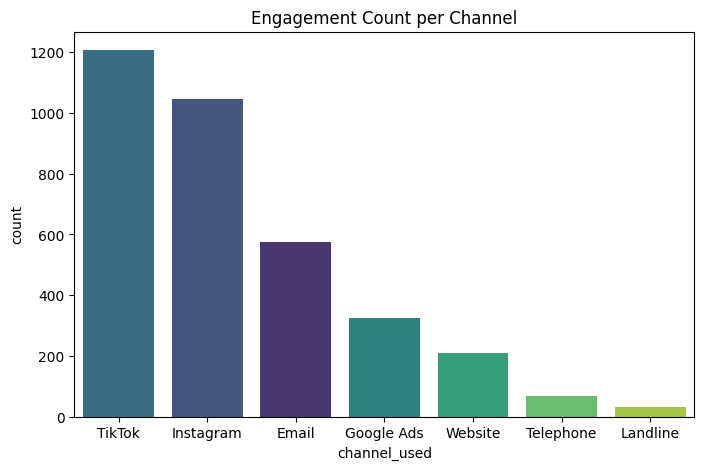

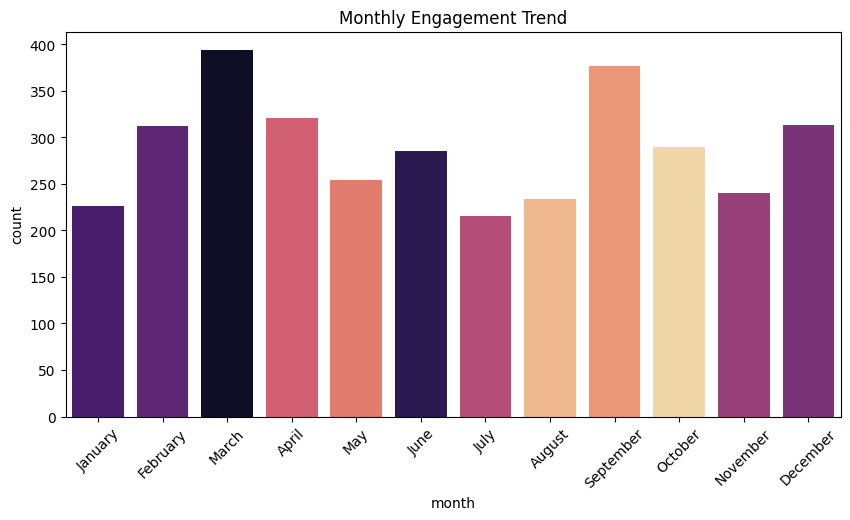

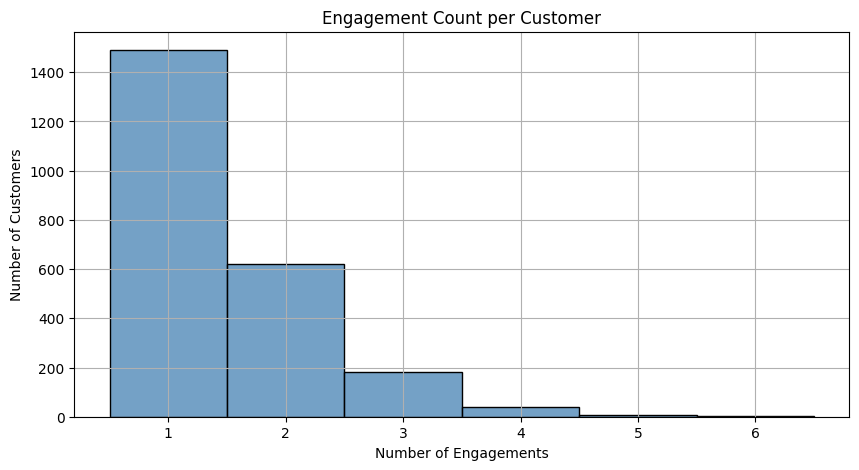

In [62]:
#verifying/visualizing logical trends/engagement patterns

import matplotlib.pyplot as plt
import seaborn as sns

# Filter only engaged rows
engaged_df = df[df['has_engaged'] == 1]

# Engagement Rate by Channel
plt.figure(figsize=(8, 5))
sns.countplot(data=engaged_df, x='channel_used', hue='channel_used', order=engaged_df['channel_used'].value_counts().index, palette='viridis', legend = False)
plt.title('Engagement Count per Channel')
plt.show()


# Engagement by Month
# Month engagement weights (for plotting)
month_weights = {
    'January': 1.2, 'February': 1.0, 'March': 0.9, 'April': 1.0,
    'May': 1.1, 'June': 0.8, 'July': 1.2, 'August': 1.0,
    'September': 1.3, 'October': 1.2, 'November': 1.4, 'December': 1.5
}

plt.figure(figsize=(10, 5))
sns.countplot(data=engaged_df, x='month', hue='month', order=month_weights.keys(), palette='magma', legend = False)
plt.title('Monthly Engagement Trend')
plt.xticks(rotation=45)
plt.show()

# Engagement Count per Customer
plt.figure(figsize=(10, 5))
customer_engagement_counts = engaged_df['customer_id'].value_counts()
sns.histplot(customer_engagement_counts, bins=range(1, 8), discrete=True, color='steelblue')
plt.title('Engagement Count per Customer')
plt.xlabel('Number of Engagements')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()